In [3]:
import os
#comment this if you are not using puffer?
os.environ['http_proxy'] = 'http://192.41.170.23:3128'
os.environ['https_proxy'] = 'http://192.41.170.23:3128'

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import os
import sys
from mne.datasets import eegbci
import glob
from IPython.display import clear_output
import numpy as np
import torch
from torch import nn
import torch.optim as optim

from mne.datasets import eegbci
from sklearn.model_selection import train_test_split
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from scipy import signal

import torch
import torch.cuda as cuda
import torch.nn as nn
from torch.autograd import Variable
import math

In [2]:
from common import EEG 

In [3]:

# home directory + datasets folder
#path = '/content/drive/MyDrive/MNE-eegbci-data/files/eegmmidb/'
path = 'physionet.org/files/eegmmidb/1.0.0'
base_url = 'https://physionet.org/files/eegmmidb/'
# subjects = [1]
runs = [3, 4, 7, 8, 11, 12]
#runs = [4, 8, 12]
#subjects = [i for i in range(1,80)]
subjects = [1]
# runs = [6,10,14]

eeg = EEG(path, base_url, subjects, runs)
raw=eeg.data_to_raw()
print(raw)
print("Raw done")
# apply filter
freq = (8., 14.)
#raw=eeg.filter(freq=freq)
#raw=eeg.data_to_raw()
print("Filter done")
#raw=eeg.raw_ica()


<RawEDF | S001R03.edf, 64 x 120000 (750.0 s), ~58.7 MB, data loaded>
Raw done
Filter done


In [4]:
raw=raw.notch_filter(50)
raw=raw.filter( 8,14, method='fir', verbose=20)

Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge: 50.62 Hz
- Upper transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 50.88 Hz)
- Filter length: 1057 samples (6.606 sec)



[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s


Filtering raw data in 6 contiguous segments
Setting up band-pass filter from 8 - 14 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 8.00
- Lower transition bandwidth: 2.00 Hz (-6 dB cutoff frequency: 7.00 Hz)
- Upper passband edge: 14.00 Hz
- Upper transition bandwidth: 3.50 Hz (-6 dB cutoff frequency: 15.75 Hz)
- Filter length: 265 samples (1.656 sec)



[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  64 out of  64 | elapsed:    0.1s finished


In [5]:
raw

<RawEDF | S001R03.edf, 64 x 120000 (750.0 s), ~58.7 MB, data loaded>

In [6]:
raw = raw.drop_channels(['FC5',
 'FC3',
 'FC1',
 'FCz',
 'FC2',
 'FC4',
 'FC6',
 'C5',
 'Cz',
 'C6',
 'CP5',
 'CP3',
 'CP1',
 'CPz',
 'CP2',
 'CP4',
 'CP6',
 'Fp1',
 'Fpz',
 'Fp2',
 'AF7',
 'AF3',
 'AFz',
 'AF4',
 'AF8',
 'F7',
 'F5',
 'F3',
 'F1',
 'Fz',
 'F2',
 'F4',
 'F6',
 'F8',
 'FT7',
 'FT8',
 'T7',
 'T8',
 'T9',
 'T10',
 'TP7',
 'TP8',
 'P7',
 'P5',
 'P3',
 'P1',
 'Pz',
 'P2',
 'P4',
 'P6',
 'P8',
 'PO7',
 'PO3',
 'POz',
 'PO4',
 'PO8',
 'O1',
 'Oz',
 'O2',
 'Iz',
 "C1",
 "C2"
                    ]
)


In [7]:
eeg.create_epochs()

>>> Create Epochs.
Used Annotations descriptions: ['T1', 'T2']
Not setting metadata
90 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 90 events and 801 original time points ...
0 bad epochs dropped


(array([[   672,      0,      1],
        [  2000,      0,      0],
        [  3328,      0,      0],
        [  4656,      0,      1],
        [  5984,      0,      1],
        [  7312,      0,      0],
        [  8640,      0,      0],
        [  9968,      0,      1],
        [ 11296,      0,      0],
        [ 12624,      0,      1],
        [ 13952,      0,      1],
        [ 15280,      0,      0],
        [ 16608,      0,      0],
        [ 17936,      0,      1],
        [ 19264,      0,      0],
        [ 20672,      0,      1],
        [ 22000,      0,      0],
        [ 23328,      0,      0],
        [ 24656,      0,      1],
        [ 25984,      0,      1],
        [ 27312,      0,      0],
        [ 28640,      0,      1],
        [ 29968,      0,      0],
        [ 31296,      0,      1],
        [ 32624,      0,      0],
        [ 33952,      0,      0],
        [ 35280,      0,      1],
        [ 36608,      0,      0],
        [ 37936,      0,      1],
        [ 3926

In [8]:
raw.ch_names

['C3', 'C4']

NOTE: plot_psd() is a legacy function. New code should use .compute_psd().plot().
Effective window size : 1.600 (s)


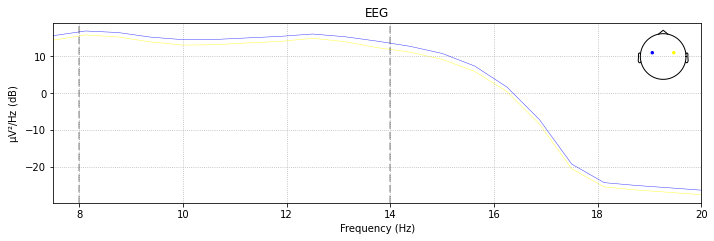

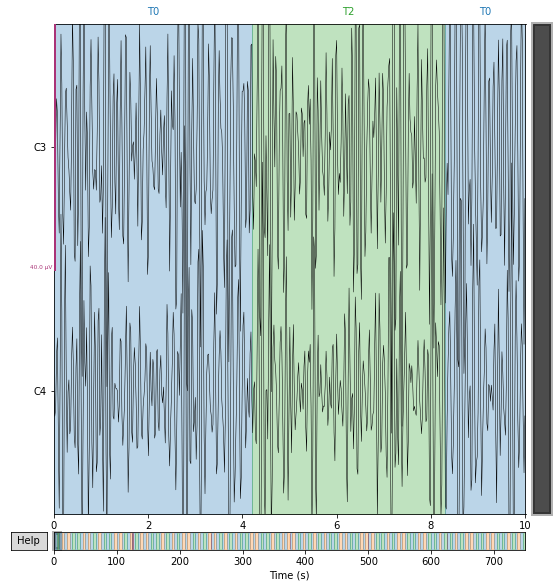

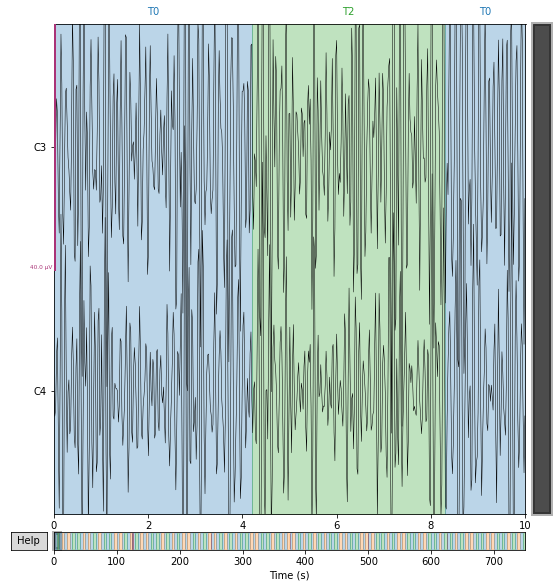

In [26]:
raw.plot_psd(fmin=7,fmax=20)
raw.plot()

In [27]:
l_vis_T1=eeg.epochs["T1"].average()
l_vis_T2=eeg.epochs["T2"].average()

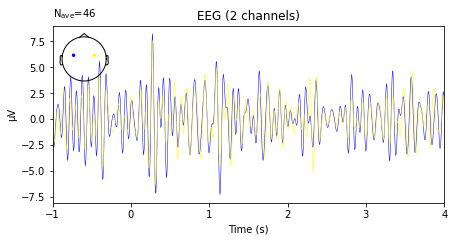

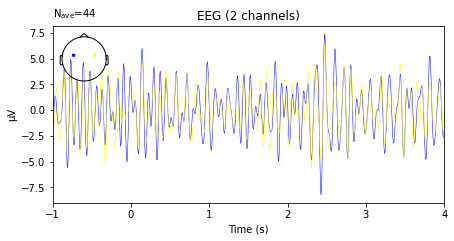

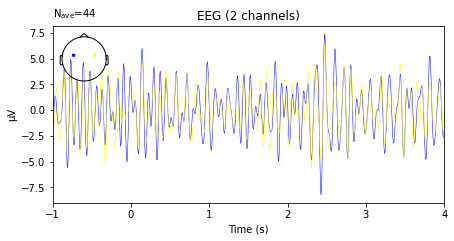

In [28]:
#l_vis_T1.plot(spatial_colors=True)
#l_vis_T2.plot(spatial_colors=True)


l_vis_T1.plot()
l_vis_T2.plot() 

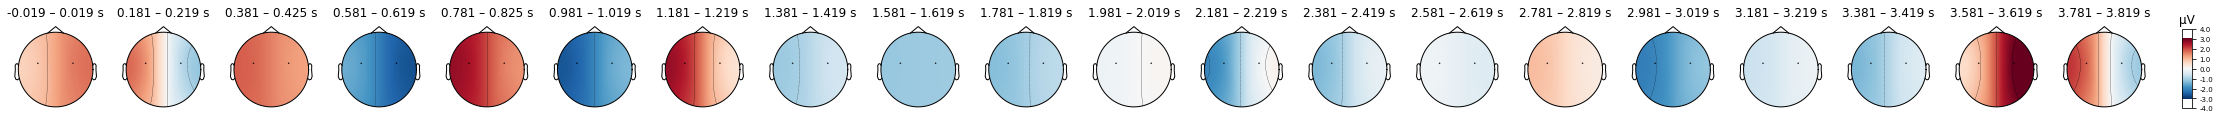

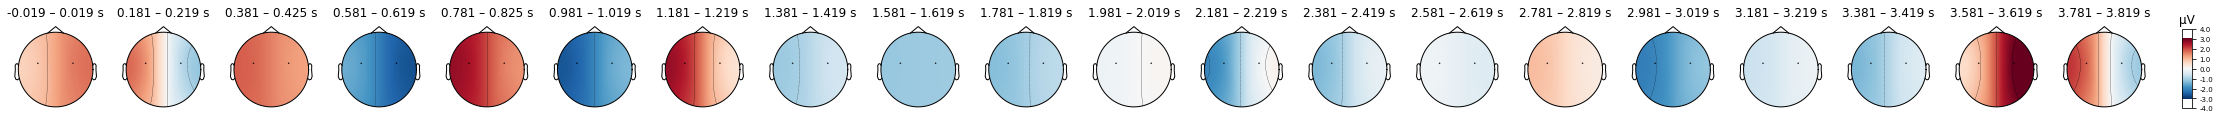

In [29]:
#left 
l_vis_T1.plot_topomap(times=list(np.arange(0, 4, 0.20)), average=0.05, ch_type="eeg")

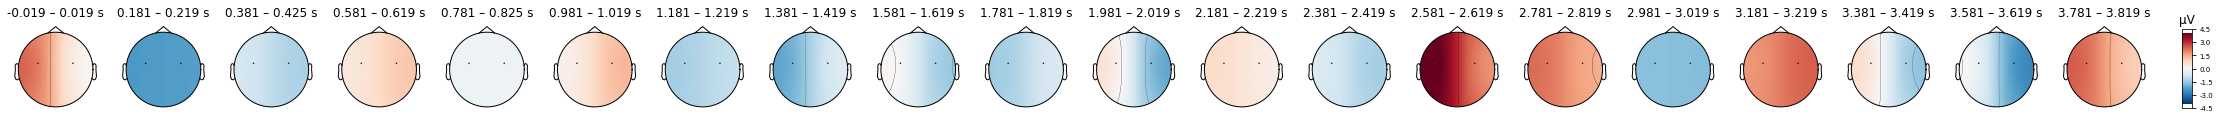

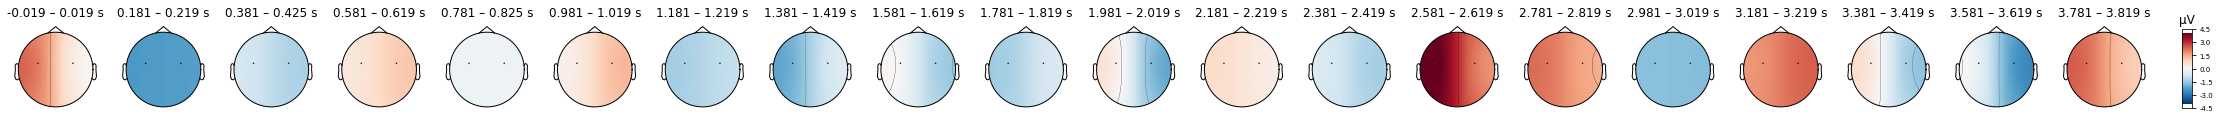

In [30]:
#right
l_vis_T2.plot_topomap(times=list(np.arange(0, 4, 0.2)), average=0.05)

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import TwoSlopeNorm
import pandas as pd
import seaborn as sns
import mne
from mne.datasets import eegbci
from mne.io import concatenate_raws, read_raw_edf
from mne.time_frequency import tfr_multitaper
from mne.stats import permutation_cluster_1samp_test as pcluster_test



In [42]:

freqs = np.arange(8, 14)  # frequencies from 2-35Hz
vmin, vmax = -1, 1.5  # set min and max ERDS values in plot
baseline = (-1,0 )  # baseline interval (in s)
cnorm = TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)  # min, center & max ERDS
kwargs = dict(n_permutations=100, step_down_p=0.05, seed=1,
              buffer_size=None, out_type='mask')  # for cluster test
tmin, tmax = -1, 4


In [43]:
epochs = eeg.epochs
event_ids = epochs.event_id


In [44]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=2)
tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


<EpochsTFR | time : [-1.000000, 4.000000], freq : [8.000000, 13.000000], epochs : 90, channels : 2, ~3.3 MB>

In [45]:
df = tfr.to_data_frame(time_format=None)
df.head()


,time,freq,epoch,condition,C3,C4
0,-1.0000,8.0,0,T2,-0.595366,-0.755343
1,-0.9875,8.0,0,T2,-0.567865,-0.744057
2,-0.9750,8.0,0,T2,-0.532088,-0.718919
3,-0.9625,8.0,0,T2,-0.507571,-0.685981
4,-0.9500,8.0,0,T2,-0.494260,-0.660663


In [46]:
df = tfr.to_data_frame(time_format=None, long_format=True)

# Map to frequency bands:
freq_bounds = {'_': 0,
               'delta': 3,
               'theta': 7,
               'alpha': 13,
               'beta': 35,
               'gamma': 140}
df['band'] = pd.cut(df['freq'], list(freq_bounds.values()),
                    labels=list(freq_bounds)[1:])

df

Converting "condition" to "category"...
Converting "epoch" to "category"...
Converting "channel" to "category"...
Converting "ch_type" to "category"...


,condition,epoch,freq,time,channel,ch_type,value,band
0,T2,0,8.0,-1.0000,C3,eeg,-0.595366,alpha
1,T2,0,8.0,-1.0000,C4,eeg,-0.755343,alpha
2,T2,0,8.0,-0.9875,C3,eeg,-0.567865,alpha
3,T2,0,8.0,-0.9875,C4,eeg,-0.744057,alpha
4,T2,0,8.0,-0.9750,C3,eeg,-0.532088,alpha
...,...,...,...,...,...,...,...,...
433075,T2,89,13.0,3.9750,C4,eeg,-0.896549,alpha
433076,T2,89,13.0,3.9875,C3,eeg,-0.746457,alpha
433077,T2,89,13.0,3.9875,C4,eeg,-0.896384,alpha
433078,T2,89,13.0,4.0000,C3,eeg,-0.749522,alpha


In [47]:
# Filter to retain only relevant frequency bands:
freq_bands_of_interest = ['delta', 'theta', 'alpha', 'beta']
df = df[df.band.isin(freq_bands_of_interest)]
df['band'] = df['band'].cat.remove_unused_categories()

# Order channels for plotting:
df['channel'] = df['channel'].cat.reorder_categories(('C3', 'C4'),
                                                     ordered=True)

df

,condition,epoch,freq,time,channel,ch_type,value,band
0,T2,0,8.0,-1.0000,C3,eeg,-0.595366,alpha
1,T2,0,8.0,-1.0000,C4,eeg,-0.755343,alpha
2,T2,0,8.0,-0.9875,C3,eeg,-0.567865,alpha
3,T2,0,8.0,-0.9875,C4,eeg,-0.744057,alpha
4,T2,0,8.0,-0.9750,C3,eeg,-0.532088,alpha
...,...,...,...,...,...,...,...,...
433075,T2,89,13.0,3.9750,C4,eeg,-0.896549,alpha
433076,T2,89,13.0,3.9875,C3,eeg,-0.746457,alpha
433077,T2,89,13.0,3.9875,C4,eeg,-0.896384,alpha
433078,T2,89,13.0,4.0000,C3,eeg,-0.749522,alpha


In [48]:

g = sns.FacetGrid(df, row='band', col='condition', margin_titles=True)
g.map(sns.lineplot, 'time', 'value', 'channel', n_boot=10)
axline_kw = dict(color='black', linestyle='dashed', linewidth=0.5, alpha=0.5)
g.map(plt.axhline, y=0, **axline_kw)
g.map(plt.axvline, x=0, **axline_kw)


g.set(ylim=(None, .5))
g.set_axis_labels("Time (s)", "ERDS (%)")
g.set_titles(col_template="{col_name}", row_template="{row_name}")
g.add_legend(ncol=2, loc='lower center')
g.fig.subplots_adjust(left=0.1, right=0.9, top=0.9, bottom=0.08)

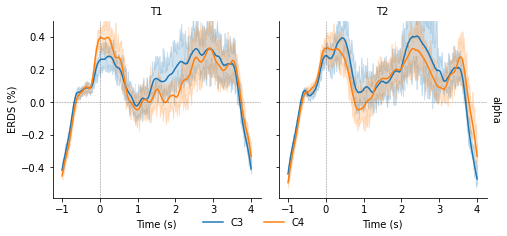

In [49]:
g.fig

In [50]:
tfr = tfr_multitaper(epochs, freqs=freqs, n_cycles=freqs, use_fft=True,
                     return_itc=False, average=False, decim=1)
tfr=tfr.crop(tmin, tmax).apply_baseline(baseline, mode="percent")
target=tfr.events[:, -1]

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s


Not setting metadata
Applying baseline correction (mode: percent)


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.2s finished


In [51]:
df = tfr[1].to_data_frame(time_format=None)
#tfr[1].crop(tmin, tmax).apply_baseline(baseline, mode="percent")
df=df[df.time > 0]
#df.head()
df

,time,freq,epoch,condition,C3,C4
161,0.00625,8.0,1,T1,0.320180,0.140763
162,0.01250,8.0,1,T1,0.312617,0.134930
163,0.01875,8.0,1,T1,0.305420,0.131523
164,0.02500,8.0,1,T1,0.298532,0.129774
165,0.03125,8.0,1,T1,0.291939,0.128421
...,...,...,...,...,...,...
4801,3.97500,13.0,1,T1,-0.366634,-0.903131
4802,3.98125,13.0,1,T1,-0.379809,-0.907151
4803,3.98750,13.0,1,T1,-0.391808,-0.909937
4804,3.99375,13.0,1,T1,-0.399632,-0.911123


In [52]:
df['C3>C4'] = df['C3'] > df["C4"]

df['C3>C4'].value_counts()


True     3436
False     404
Name: C3>C4, dtype: int64

In [56]:
result=[]
for i in range(epochs.events.shape[0]):
    df = tfr[i].to_data_frame(time_format=None)
    df=df[df.time > 0]
    mean_C3=df["C3"].mean(axis = 0)
    mean_C4=df["C4"].mean(axis = 0)
    if mean_C3 > mean_C4 :
        result.append(0)
    if mean_C3 < mean_C4 :
        result.append(1)

In [57]:
count_true = 0
count_false = 0 
for i in range(target.shape[0]):
    if result[i] == target[i]:
        count_true +=1
    if result[i] != target[i] :
        count_false +=1
    acc_true = (count_true/target.shape[0])*100
    acc_false = (count_false/target.shape[0])*100
print("acc_true : {} %".format(acc_true))
print("acc_false : {} %".format(acc_false))

acc_true : 54.44444444444444 %
acc_false : 45.55555555555556 %


In [58]:
target

array([1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0,
       0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0,
       0, 1, 1, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       0, 1])